In [4]:
import pandas as pd
import numpy as np

# from IPython.core.display import HTML
# HTML("<style>.container{ width: 100% !important; }</style>")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

pd.options.display.float_format = '{:,.2f}'.format

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 4

# pd.set_option('display.max_columns', 10)     
# pd.set_option('display.width', 500)
# pd.set_option('display.max_rows', 15)

In [ ]:
# goals
# accidents per month
# accidents by day of week
# accidents by day of week
# accidents by weather

## download the data
and look at it 

In [2]:
df = pd.read_csv('../Downloads/Metro_Nashville___Davidson_County_Traffic_Crashes__2018_.csv',parse_dates=['Date and Time'])
# df.head()
df[:1].T

,0
Accident Number,20180257382
Date and Time,2018-03-20 22:05:00
Number of Motor Vehicles,2.00
Number of Injuries,0
Number of Fatalities,0
Property Damage,NaN
Hit and Run,Y
Reporting Officer,240981
Collision Type Code,4
Collision Type Description,ANGLE


In [39]:
df.shape
df.dtypes
df["Date and Time"].describe()

(22360, 25)

Accident Number                        int64
Date and Time                 datetime64[ns]
Number of Motor Vehicles             float64
Number of Injuries                     int64
Number of Fatalities                   int64
Property Damage                       object
Hit and Run                           object
Reporting Officer                      int64
Collision Type Code                    int64
Collision Type Description            object
Weather Code                         float64
Weather Description                   object
Illumination Code                    float64
Illumination Description              object
Harmful Code                          object
Harmful Code Description              object
Street Address                        object
City                                  object
State                                 object
Zip                                  float64
RPA                                  float64
Precinct                              object
Latitude  

count                   22360
unique                  19553
top       2018-06-29 00:00:00
freq                       15
first     2018-01-01 00:00:00
last      2018-08-29 21:00:00
Name: Date and Time, dtype: object

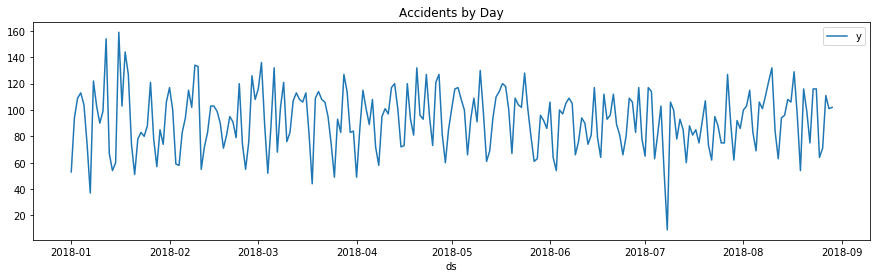

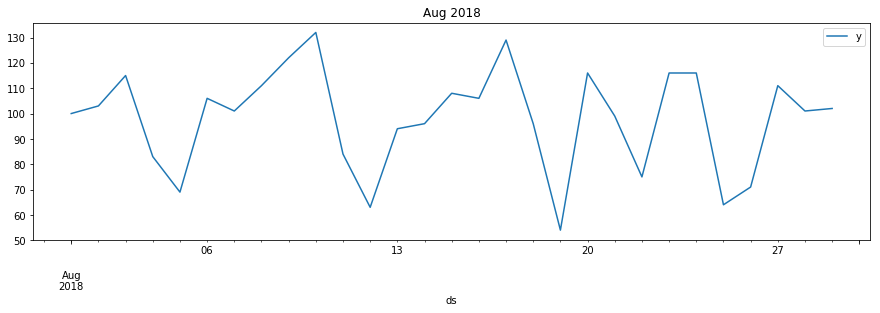

In [42]:
dfByDay = df.groupby(df["Date and Time"].dt.date)['Accident Number'].count().reset_index()
dfByDay.columns = ['ds','y']

fig = dfByDay.plot(x='ds',title='Accidents by Day')

dfByDay['ds'] = pd.to_datetime(dfByDay.ds)
fig2 = dfByDay.set_index('ds')['2018-08'].plot(title='Aug 2018')

## what are monthly and weekly trends

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nathan/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


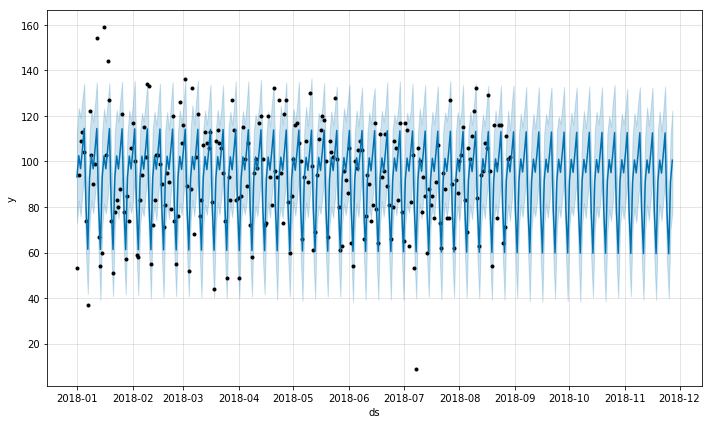

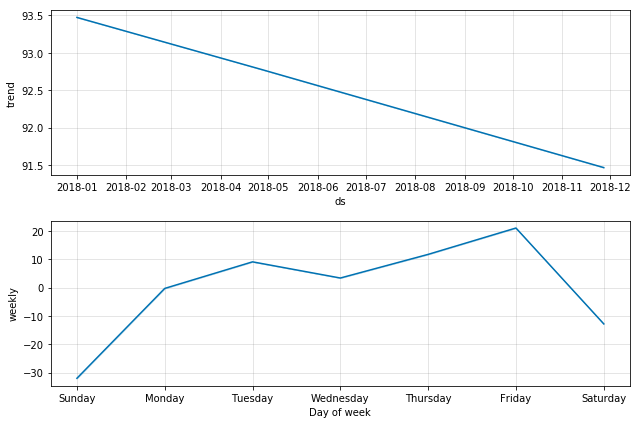

In [16]:
from fbprophet import Prophet

m = Prophet()
m.fit(dfByDay)
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

looks like we're trending down by month
and fridays are the worst day of week

### which factors contribute to accidents?
weather, day of week?

In [63]:
df['Weather Description'].value_counts()
df['Illumination Description'].value_counts()
# df['Harmful Code Description'].value_counts()

CLEAR                16035
CLOUDY                2917
RAIN                  2757
SNOW                   275
UNKNOWN                212
SLEET, HAIL             52
FOG                     30
OTHER (NARRATIVE)       20
BLOWING SNOW            13
SEVERE CROSSWIND         2
SMOG, SMOKE              1
Name: Weather Description, dtype: int64

DAYLIGHT                 16240
DARK - LIGHTED            4055
DARK - NOT LIGHTED        1112
DUSK                       362
UNKNOWN                    219
DAWN                       207
Dark-Unknown Lighting      119
OTHER                       27
Name: Illumination Description, dtype: int64

In [81]:
df['weather'] = df['Weather Description'].apply(lambda m: 0 if m == 'CLEAR' else 1)
df['weather'].value_counts()

df['visibility'] = df['Illumination Description'].apply(lambda m: 0 if m == 'DAYLIGHT' else 1)
df['visibility'].value_counts()

0    16035
1     6325
Name: weather, dtype: int64

0    16240
1     6120
Name: visibility, dtype: int64

In [54]:
df['dow'] = df["Date and Time"].dt.dayofweek  #0 is Monday, 6 Sat.  #per dt.day_name()
df['dow'].value_counts()

4    3867
1    3563
3    3551
2    3363
0    3235
5    2717
6    2064
Name: dow, dtype: int64

In [82]:
targets = ['Number of Injuries','Number of Motor Vehicles','Number of Fatalities']
df2 = df.groupby(['dow','visibility','weather'],as_index=False)[targets].sum()
df2.head()

,dow,visibility,weather,Number of Injuries,Number of Motor Vehicles,Number of Fatalities
0,0,0,0,666,"3,677.00",4
1,0,0,1,265,"1,417.00",0
2,0,1,0,201,923.00,4
3,0,1,1,65,397.00,0
4,1,0,0,704,"4,143.00",1


In [95]:
?GradientBoostingRegressor

In [104]:
# from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

for t in targets:
    X = df2.drop(targets, axis = 1)
    Y = df2[t]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 5)
    
    clf = GradientBoostingRegressor();
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)

#     plt.figure(figsize=(12, 6))
#     plt.scatter(Y_test, Y_pred);
#     plt.plot([0, 50], [0, 50], '--k');
#     plt.axis('tight')
# #     plt.xlabel('True price ($1000s)')
# #     plt.ylabel('Predicted price ($1000s)')
#     plt.tight_layout()
# r2_score(Y_pred,Y_test)
    print("\n\n-------------------\n")
    rmse = mean_squared_error(Y_pred,Y_test) ** .5
    print("RMSE: {:.2f} of {} for {}".format(rmse,Y_test.mean(),t))
#     print("RMS: %r " % np.sqrt(np.mean((Y_pred - Y_test) ** 2)))
    pd.DataFrame(clf.feature_importances_,index= X_train.columns,columns=[t])\
        .sort_values(t,ascending=False).T

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)



-------------------

RMSE: 152.80 of 227.5 for Number of Injuries


,weather,visibility,dow
Number of Injuries,0.44,0.31,0.25


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)



-------------------

RMSE: 1215.39 of 1053.3 for Number of Motor Vehicles


,dow,weather,visibility
Number of Motor Vehicles,0.39,0.36,0.24


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)



-------------------

RMSE: 2.11 of 2.2 for Number of Fatalities


,dow,weather,visibility
Number of Fatalities,0.56,0.34,0.10


- Root mean squared error is lowest in predicting # fatalities
    - Weather also affects fatalities